### Exercise 1

Let $\theta_1$ and $\theta_2$ be real valued parameters of the model

$$
y = \frac{\theta_1 x}{\theta_2 + x}.
$$

a. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$  and use HMC algorithm to find their posterior distributions, conditioning on the observations

$$
x=(28,55,110,138,225,375)\\
y=(0.053,0.060,0.112,0.105,0.099,0.122).
$$

b. Discuss how different parameters for both priors and the HMC algorithm lead to different estimates. 

c. Plot the most reliable posterior distributions, according to convergence checks on the traces.

#### Proposed solution:

#### a.

We can choose as prior for both $\theta_1$ and $\theta_2$ a normal distribution so that:
 * $\theta_1\sim \mathcal{N}(\mu_1, \sigma_1^2)$
 * $\theta_2\sim \mathcal{N}(\mu_2, \sigma_2^2)$

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC
import random
import numpy as np
pyro.set_rng_seed(42)

In [2]:
#write our model
def model(x, prior1, prior2):
    theta_1 = pyro.sample('theta1', prior1)
    theta_2 = pyro.sample('theta2', prior2)
    y = pyro.param('y', (theta_1)*x/((theta_2)+x))
    return y

x = torch.tensor([28,55,110,138,225,375])
obs = torch.tensor([0.053,0.060,0.112,0.105,0.099,0.122]) #y

#condition on the observation 
conditioned_model = pyro.condition(model, data={"measurement": obs})

In [3]:
hmc_kernel = HMC(model=conditioned_model) # transition kernel

mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=1000, num_chains=3)

#### b.

Now I run the above defined mcmc varying the parameters of the two priors for $\theta_1$ and $\theta_2$.

I start by checking what happens when fixing $\mu = 0$ for both priors and varying $\sigma^2$.

In [4]:
#both standard normals
mcmc.run(x, dist.Normal(0,1), dist.Normal(0,1))
mcmc.summary()





                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1     -0.11      1.00     -0.12     -1.62      1.61    211.16      1.01
    theta2      0.07      0.91      0.07     -1.33      1.54    134.08      1.03

Number of divergences: 0


In this case both chains seem to have converged to equilibrium distribution, using as a rule of thumb the fact that $\hat{R}<1.1$ implies convergence. However the effective sample size is significantly lower for the chain for $\theta_2$ wrt to the one for $\theta_1$. 

In [5]:
mcmc.run(x, dist.Normal(0,1.5), dist.Normal(0,3))
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1     -0.09      1.52     -0.12     -2.57      2.36    386.24      1.01
    theta2     -0.73      2.86     -0.58     -6.03      3.40     24.66      1.12

Number of divergences: 0


In this case we can see an improvement in the effective sample size for the chains for $\theta_1$, with unchanged $\hat{R}$ statistics, while the situation is much worse for the chain for $\theta_2$.

To go deeper in the analysis, we can visualize the three chains for both $\theta_1$ and $\theta_2$:

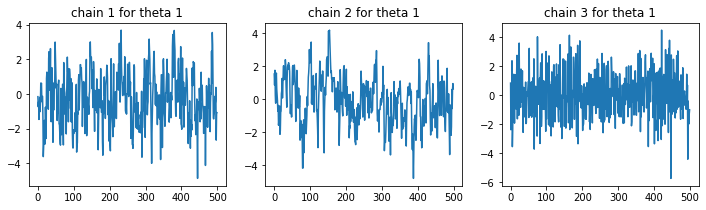

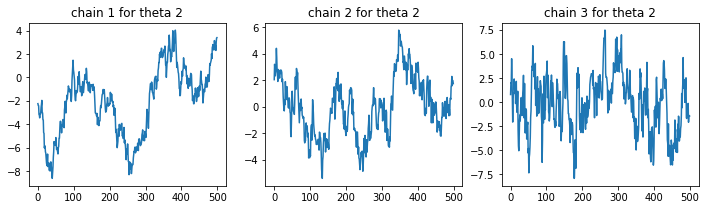

In [6]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)
chains1 = mcmc_samples['theta1']

n_chains1, n_samples1 = chains1.shape

fig, ax = plt.subplots(1, n_chains1, figsize=(12,3))
for i, chain in enumerate(chains1):
    sns.lineplot(x=range(n_samples1), y=chain, ax=ax[i])
    ax[i].set_title("chain "+str(i+1)+" for theta 1")


chains2 = mcmc_samples['theta2']

n_chains2, n_samples2 = chains2.shape

fig, ax = plt.subplots(1, n_chains2, figsize=(12,3))
for i, chain in enumerate(chains2):
    sns.lineplot(x=range(n_samples2), y=chain, ax=ax[i])
    ax[i].set_title("chain "+str(i+1)+" for theta 2")

As expected, the chains for $\theta_2$ behave very different among each other.

More trials have been done keeping the mean fixed to 0 for both priors, but still the best result is obtained with two standard normals. 

In what follows I drop this hypothesis and run some other tests.

In [4]:
mcmc.run(x, dist.Normal(5,10), dist.Normal(2,2))
mcmc.summary()





                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      3.60      9.80      3.30    -13.36     18.56    146.40      1.03
    theta2      1.97      2.01      1.98     -1.23      5.25    158.45      1.04

Number of divergences: 0


In [4]:
mcmc.run(x, dist.Normal(2,2), dist.Normal(2,2))
mcmc.summary()





                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      1.89      1.99      1.84     -1.26      5.19    179.36      1.01
    theta2      2.16      1.85      2.20     -0.70      5.27    144.48      1.03

Number of divergences: 0


Other attemps have been made, but these seem to be the more reliable. 

We can try to change the priors for $\theta_1$ and $\theta_2$. In what follows I report the most promising trials I made.

We can assume as priors:
 * $\theta_1\sim Exp(\lambda)$
 * $\theta_2\sim \mathcal{N}(\mu, \sigma^2)$

In [6]:
#lambda = 3, mu = 5, sigma^2=5
mcmc.run(x, dist.Exponential(3), dist.Normal(5,5))
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.34      0.34      0.24      0.00      0.78    312.54      1.00
    theta2      4.22      4.27      3.57     -3.38     11.37    248.39      1.02

Number of divergences: 0


We can assume as priors:
 * $\theta_1\sim Exp(\lambda_1)$
 * $\theta_2\sim Exp(\lambda_2)$

In [7]:
#lambda_1 = 5, lambda_2 = 3
mcmc.run(x, dist.Exponential(5), dist.Exponential(3))
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.22      0.22      0.16      0.00      0.48    219.61      1.00
    theta2      0.30      0.33      0.19      0.00      0.72    390.29      1.01

Number of divergences: 0


The last two trials seem to be most reliable, for the high value of `n_eff` and the low value of `r_hat`. 

We can now try to change the parameters for the HMC algorithm, and test on the same prior assumptions made above.

Again, in what follows I report the most significant trials I made.

In [4]:
#increase the number of samples 
mcmc2 = MCMC(hmc_kernel, num_samples=2000, warmup_steps=500, num_chains=3)

In [5]:
mcmc2.run(x, dist.Normal(5,10), dist.Normal(2,2))
mcmc2.summary()





                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      5.05      9.95      5.10    -10.72     21.84    347.11      1.00
    theta2      2.17      2.05      2.22     -1.39      5.31    226.24      1.01

Number of divergences: 0


In [24]:
mcmc2.run(x, dist.Exponential(5), dist.Exponential(3))
mcmc2.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1     -2.14      1.22     -1.96     -3.97     -0.27    572.69      1.00
    theta2     -1.71      1.26     -1.51     -3.61      0.25    429.66      1.02

Number of divergences: 0


In [5]:
mcmc2.run(x, dist.Exponential(3), dist.Normal(5,5))
mcmc2.summary()





                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.33      0.32      0.23      0.00      0.76   2364.37      1.00
    theta2      5.10      4.96      5.09     -2.64     13.53    959.34      1.00

Number of divergences: 0


This last seem to be the most reliable choice of priors for $\theta_1$ and $\theta_2$, namely:
 * $\theta_1\sim Exp(3)$
 * $\theta_2\sim \mathcal{N}(5,5)$

#### c.

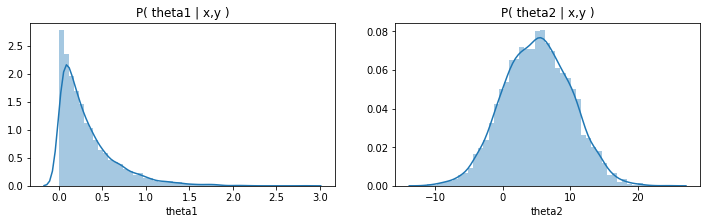

In [6]:
mcmc_samples = mcmc2.get_samples(group_by_chain=True)
chain1 = mcmc_samples['theta1']
chain2 = mcmc_samples['theta2']


fig, ax = plt.subplots(1, 2, figsize=(12,3))
sns.distplot(chain1, ax=ax[0])
ax[0].set_title("P( theta1 | x,y )")
ax[0].set_xlabel("theta1")
sns.distplot(chain2, ax=ax[1])
ax[1].set_title("P( theta2 | x,y )")
ax[1].set_xlabel("theta2")
plt.show()

### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler for $x$ which takes as inputs the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

#### Proposed solution:

#### a.

In order to simulate bivariate Normal using the Gibbs sampler, we need to know the conditional distributions $p(x_1|x_2)$ amd $p(x_2|x_1)$. 

From the theory on multivariate Gaussians, we know that if two sets of variables are jointly Gaussian, then the conditional distribution of one set conditioned on the other is again Gaussian. Specifically for the bivariate case those conditional distributions are:

$p(x_1|x_2) = \mathcal{N}(x_1|\mu_1+\Sigma_{12}\Sigma_{22}^{-1}(x_2-\mu_2), \Sigma_{11}-\Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21})$

$p(x_2|x_1) = \mathcal{N}(x_2|\mu_2+\Sigma_{12}\Sigma_{11}^{-1}(x_1-\mu_1), \Sigma_{22}-\Sigma_{12}\Sigma_{11}^{-1}\Sigma_{21})$.

Hence in our specific case we get:

* $p(x_1|x_2) = \mathcal{N}(x_1| \rho x_2, 1-\rho^2)$
* $p(x_2|x_1) = \mathcal{N}(x_2| \rho x_1, 1-\rho^2)$

In [28]:
#Gibbs sampler for bivariate normal
#mu and sigma are the mean vector and variance matrix of the bivariate normal
#they can be both torch.tensor or np.array (or lists)
def Gibbs_sampler_bn(iters, warmup, mu, sigma): 
    #we set initial values to 0
    x_1 = torch.zeros(iters+warmup)
    x_2 = torch.zeros(iters+warmup)
    #just for practicality
    scale_1 = sigma[0][0]-(sigma[0][1]**2)/sigma[1][1]
    scale_2 = sigma[1][1]-(sigma[0][1]**2)/sigma[0][0]
    for i in range(1,iters+warmup):
        loc_2 = mu[1]+(sigma[0][1]/sigma[0][0])*(x_1[i-1]-mu[0])
        x_2[i] = pyro.sample('x2', dist.Normal(loc_2, scale_2))
        loc_1 = mu[0]+(sigma[0][1]/sigma[1][1])*(x_2[i-1]-mu[1])
        x_1[i] = pyro.sample('x1', dist.Normal(loc_1, scale_1))
    #need to discard the warmup steps
    return x_1[warmup:], x_2[warmup:]

In [57]:
#testing previous funciton
iters = 5000
warmup = int(iters/2)

mu=torch.zeros(2)
rho = 0.5 #just an example for testing
cov = [[1,rho],[rho,1]]
sigma = torch.tensor(cov)

x, y = Gibbs_sampler_bn(iters, warmup, mu, sigma)

Text(0.5, 1.0, 'sample from p(x2|x1)')

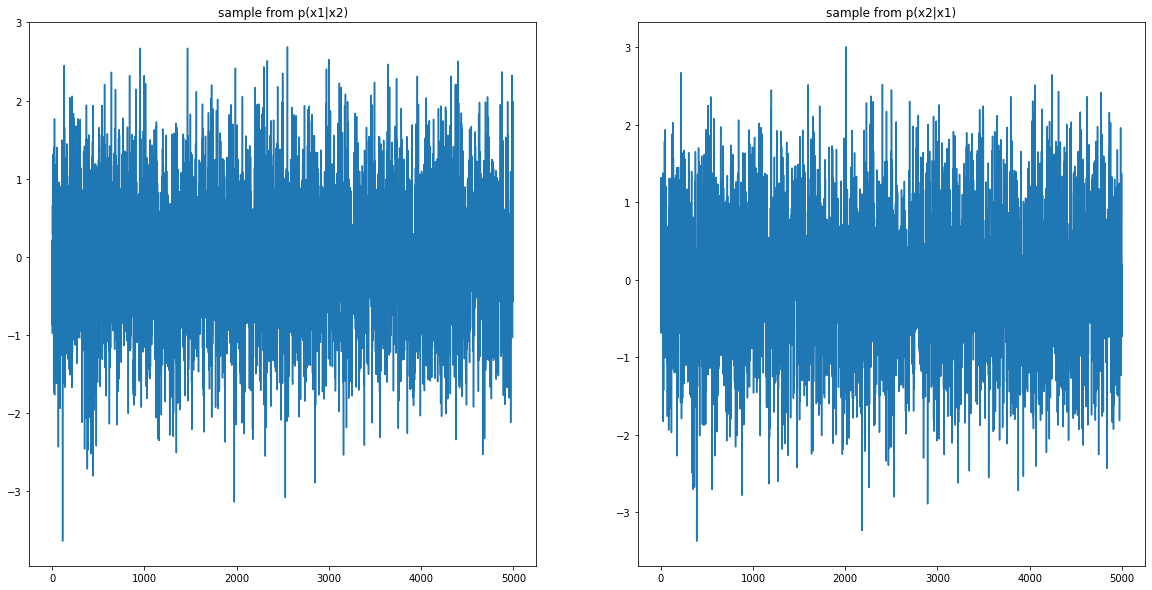

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.lineplot(range(len(x)), x, ax=ax[0])
ax[0].set_title("sample from p(x1|x2)")
sns.lineplot(range(len(y)), y, ax=ax[1])
ax[1].set_title("sample from p(x2|x1)")

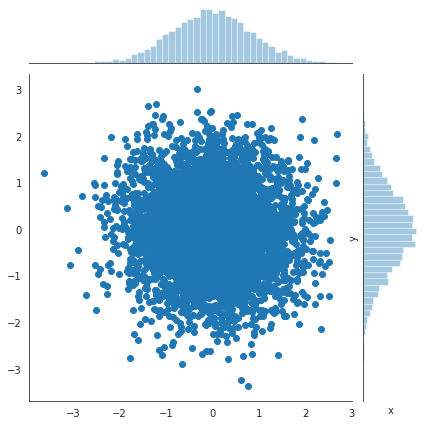

In [64]:
with sns.axes_style("white"):
        sns.jointplot(x, y);

plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### b.

In [44]:
mu1 = chain1.mean()
mu2 = chain2.mean()
mu = torch.tensor([mu1, mu2])

v1 = chain1 - mu1
v2 = chain2 - mu2
v12 = v1*v2
chain_len = len(chain1[0])
cov_12 = torch.sum(v12/chain_len) #covariance btw chains of mcmc

sigma = torch.tensor([[1,cov_12],[cov_12, 1]])

tensor([[1.0000, 0.0735],
        [0.0735, 1.0000]])

In [45]:
#run the sampler
t1, t2 = Gibbs_sampler_bn(iters, warmup, mu, sigma)

Text(0.5, 1.0, 'sample from p(theta2|theta1)')

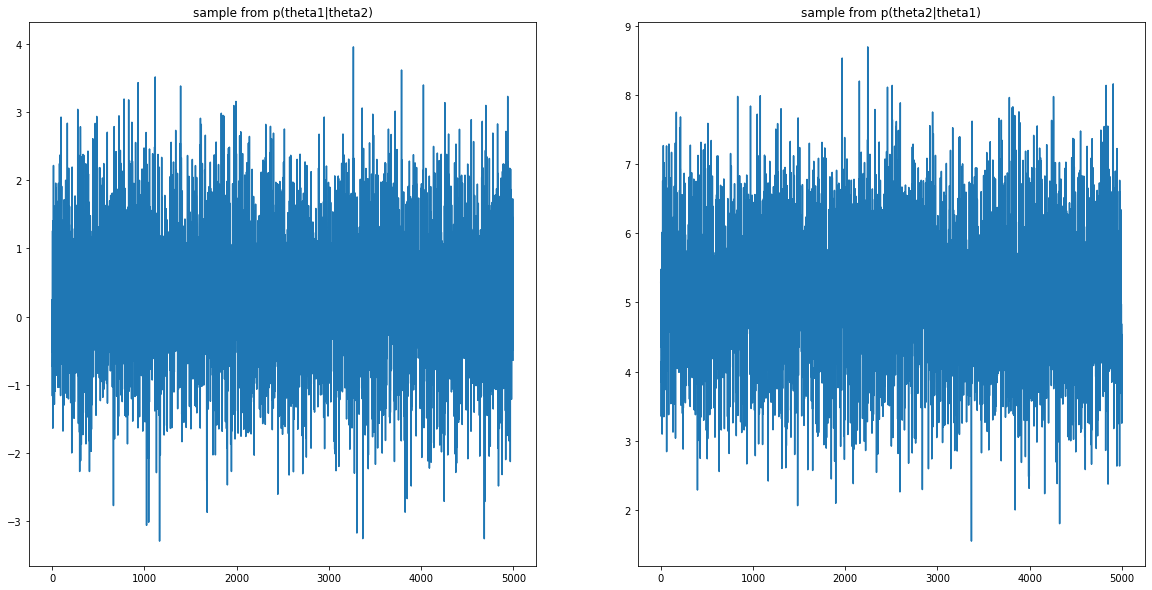

In [46]:
#check graphically convergence of the chains
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.lineplot(range(len(t1)), t1, ax=ax[0])
ax[0].set_title("sample from p(theta1|theta2)")
sns.lineplot(range(len(t2)), t2, ax=ax[1])
ax[1].set_title("sample from p(theta2|theta1)")

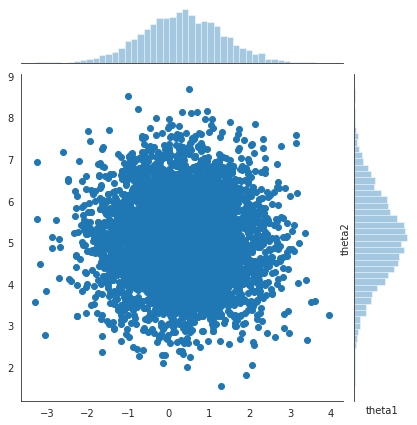

In [63]:
#since rho is low, I expect the projection of the bivariate normal
#in the plane to be almost circular
with sns.axes_style("white"):
        sns.jointplot(t1, t2);

plt.xlabel("theta1")
plt.ylabel("theta2")
plt.show()